# Artificial Neural Network

***ABSTRACT***

***In this hands-on practice we build a self-defined Neural Network from scratch by defining the parameters $\Theta$, the Sigmoid function, Derivative of Sigmoid, Cross-Entropy  function, Mean Aquared Error function, and performing all the calculations for Forward Propagation and Backpropagtion to train the neural network. We also collect the cost history and accuracy score during the calculation and finally plot the cost diagram and accuracy diagram to show how the process is going. We use the Churn_Modelling Dataset for the training of our neural network, which is consist of 10,000 bank customer data, we build this Neural Network model to predict whether a customer will left or remain in the bank. Finally we received the accuracy score of 0.84.***


## 1. Churn_Modelling Dataset

The Churn Modelling dataset contains customers information of a bank with a flag that s/he exits from the bank within 6 months. We will build an ANN to learn from the dataset and predict if a customer will leave the bank or not

### 1.1 Importing the dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

datafile = 'https://floobits.com/calvinlow18/ANN/raw/Churn_Modelling.csv'
dataset = pd.read_csv(datafile)
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [0]:
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values

#y shape looks like (m,), make it looks like (m,1)
y = y[:,np.newaxis]    


### 1.2 Encoding categorical data and Feature Scaling

Encode the country name (string)  and female/male (string) as One Hot Encoding.
Standard scaler other numeric data

Also need One Hot Encoding, see [Label Encoder vs. One Hot Encoder](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

preprocess = make_column_transformer(
    (OneHotEncoder(),[1,2]),
    (StandardScaler(),[0,3,4,5,6,7,8,9])
    #(MinMaxScaler(feature_range=(0, 1)),[0,3,4,5,6,7,8,9])
)

X = preprocess.fit_transform(X)

m = X.shape[0]
X = np.hstack((np.ones((m,1)), X))

### 1.3 Splitting the dataset into the Training set and Test set


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(8000, 14)
(2000, 14)
(8000, 1)
(2000, 1)


## 2. Build a Neural Network from scratch

![Neural Network Model](https://raw.githubusercontent.com/jchen8000/MachineLearning/master/images/NeuralNetwork.png)

### 2.1 Cross-Entropy Cost Function

> ## $ \min_\Theta J(\Theta)=-\frac{\mathrm{1} }{m} \sum_{i=1}^{m}  \sum_{k=1}^{K}\left[ y_k^{(i)} log((h_\Theta(x^{(i)}))_k) + (1 - y_k^{(i)}) log (1 - (h_\Theta(x^{(i)}))_k) \right]  + \frac{\mathrm{\lambda}}{2m}  \sum_{l=1}^{L-1} \sum_{i=1}^{S_l}\sum_{j=1}^{S_l+1}( \Theta_{ji}^{(l)})^2$

> Where $ h_\Theta(x)  \in  \mathbb{R}^K, (h_\Theta(x))_i = i^{th} output  $

> $ L = $ total no. of layers in neural network

> $ S_l = $ no. of units (not couning bias unit ) in layer $ l $

> ### Think of $ J(\Theta) \approx ( h_\Theta(x^{(i)}) - y^{(i)} ) ^2 $

### 2.2 Sigmoid Function and Derivative of Sigmoid

*  **Sigmoid Function:**
> ## $ g(z) = sigmoid(z) = \frac{\mathrm{1} }{\mathrm{1} + e^{-z} }  $


*  **Derivative of Sigmoid Function:**
> ## $\frac{\mathrm{d} }{\mathrm{d} z}g(z) = g(z)(1-g(z)) $

### 2.3 Backpropagation

> ## $  \delta^{(3)}_j = a_j^{(3)} - y_j $,  ( total number of layers $ L = 3 $ )

> ## $  \delta^{(2)} = ( \Theta^{(2)} )^T  \delta^{(3)} .* g'(z^{(2)}) $

> ## $  \delta^{(1)} = ( \Theta^{(1)} )^T  \delta^{(2)} .* g'(z^{(1)}) $

In [0]:
class Neural_Network(object):
  def __init__(self, inputSize, hiddenSize, outputSize, lmbda):
  #parameters
    self.inputSize = inputSize
    self.outputSize = outputSize
    self.hiddenSize = hiddenSize
    self.lmbda = lmbda
    
  #weights
    epsilon = 0.2
    np.random.seed(3)
    self.theta1 = np.random.randn(self.inputSize, self.hiddenSize)  * 2 * epsilon - epsilon
    self.theta2 = np.random.randn(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    #self.theta1 = np.random.rand(self.inputSize, self.hiddenSize) * 2 * epsilon - epsilon
    #self.theta2 = np.random.rand(self.hiddenSize, self.outputSize) * 2 * epsilon - epsilon
    
  #history
    self.error_history =  [] 
    self.cost_history =  [] 
    self.accuracy_history = []

    
  # Forward Propagation
  def forward(self, X):
        
    #Go from input to hidden layer, apply Sigmoid activation function
    self.z = X @ self.theta1 
    self.z2 = self.sigmoid(self.z) 
    
    #Go from hidden layer to output, apply Sigmoid activation function
    self.z3 = self.z2 @ self.theta2 
    output = self.sigmoid(self.z3) 
    
    return output

  # Sigmoid activation function
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))

  # Derivative of Sigmoid
  def sigmoidDerivative(self, s):
    
    return s * (1 - s)

  # Backward Propafation
  def backward(self, X, y, output):
    
    #delta of output layer: calculate output error, and apply derivative of Sigmoid to it
    self.o_error = y - output 
    self.o_delta = self.o_error * self.sigmoidDerivative(output) 
    
    #calculate delta of hidden layer: calculate hidden layer error, and apply derivative of Sigmoid to it
    self.z2_error = self.o_delta @ self.theta2.T
    self.z2_delta = self.z2_error * self.sigmoidDerivative(self.z2) 

    #Update theta1 and theta2
    self.theta1 += X.T @ self.z2_delta 
    self.theta2 += self.z2.T @ self.o_delta 
 

  # Cross Entropy Cost Function with regulation factors
  def cross_entropy_cost(self, X, y ):
    m = len(y)
    y_output = self.forward(X)
    
    #calculate based on Cross-Entropy formula
    c1 = y * np.log(y_output)
    c2 = (1-y) * np.log(1-y_output)
    c = np.sum(c1 + c2)
    
    #add regulation factors
    r1 = np.sum(np.sum(np.power(self.theta1,2), axis = 1))
    r2 = np.sum(np.sum(np.power(self.theta2,2), axis = 1))
    
    return np.sum(c / (-m)) + ((r1 + r2) * self.lmbda) / (2*m)

  # MSE - Mean Aquared Error
  def mean_squared_error(self, X, y):
    return (np.square(y - self.forward(X))).mean(axis=None)

  # Train (Fit) the neural network
  def fit(self, X, y, epoch):
    for i in range(epoch):
      output = self.forward(X)
      self.backward(X, y, output )
      acry = accuracy_score(y, (output >= 0.5) )
      cost = self.cross_entropy_cost(X, y)
      loss = self.mean_squared_error(X, y)
      self.error_history.append(loss)
      self.cost_history.append(cost)
      self.accuracy_history.append(acry)
      
      #print output every 20 epoch
      if i % 20 == 0:
        print("epoch:[", i, "], Cross-Entropy:", str(cost), "; MSE:", str(loss) + "; Accuracy:", str(acry)  )

  # Prediction
  def predict(self, X):
    return self.forward(X)
  
  # Get the cost history gethered during training
  def get_cost_histroy(self):
    return self.cost_history
  
  # Get the error history gethered during training
  def get_error_histroy(self):
    return self.loss_history

  # Get the accuracy history gethered during training
  def get_accuracy_histroy(self):
    return self.accuracy_history  
  
  # Get the parameters (or weight) of the neural network
  def get_weight(self):
    return self.theta1, self.theta2


In [0]:
def plotCost(cost_history, epoch):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(cost_history)),cost_history,'bo')
    plt.grid(True)
    plt.title("Cross-Entropy Cost")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy Cost")
    dummy = plt.xlim([-0.05*epoch,1.05*epoch])
    dummy = plt.ylim([min(cost_history)-0.2*(max(cost_history)-min(cost_history)), max(cost_history)+0.2*(max(cost_history)-min(cost_history))])

    
def plotAccuracy(accuracy_history, epoch):
    plt.figure(figsize=(10,6))
    plt.plot(range(len(accuracy_history)),accuracy_history,'r.')
    plt.grid(True)
    plt.title("Accuracy Score")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Score")
    dummy = plt.xlim([-0.05*epoch,1.05*epoch])
    dummy = plt.ylim([min(accuracy_history)-0.2*(max(accuracy_history)-min(accuracy_history)), max(accuracy_history)+0.2*(max(accuracy_history)-min(accuracy_history))])
  
  
    

In [0]:
nnModel = Neural_Network( inputSize=14, 
                     hiddenSize=3, 
                     outputSize=1, 
                     lmbda=0.5 )


epoch = 1000
nnModel.fit(X_train, y_train, epoch)


epoch:[ 0 ], Cross-Entropy: 33.235267636400664 ; MSE: 0.19252586210041667; Accuracy: 0.796
epoch:[ 20 ], Cross-Entropy: 18.43699418484582 ; MSE: 0.15573892935668437; Accuracy: 0.806875
epoch:[ 40 ], Cross-Entropy: 15.270799631981637 ; MSE: 0.15097967720876326; Accuracy: 0.813875
epoch:[ 60 ], Cross-Entropy: 13.335598636593584 ; MSE: 0.14762797121049806; Accuracy: 0.815125
epoch:[ 80 ], Cross-Entropy: 12.876321876838642 ; MSE: 0.14602117669414041; Accuracy: 0.816625
epoch:[ 100 ], Cross-Entropy: 11.626293164350475 ; MSE: 0.14694967450111746; Accuracy: 0.818375
epoch:[ 120 ], Cross-Entropy: 11.610907251199022 ; MSE: 0.1445570398679851; Accuracy: 0.820875
epoch:[ 140 ], Cross-Entropy: 11.47426813500683 ; MSE: 0.14430755859141084; Accuracy: 0.823
epoch:[ 160 ], Cross-Entropy: 11.274085051298051 ; MSE: 0.14534529412168984; Accuracy: 0.821125
epoch:[ 180 ], Cross-Entropy: 11.574058523684123 ; MSE: 0.14552681739653633; Accuracy: 0.819625
epoch:[ 200 ], Cross-Entropy: 11.286516266241422 ; MSE:

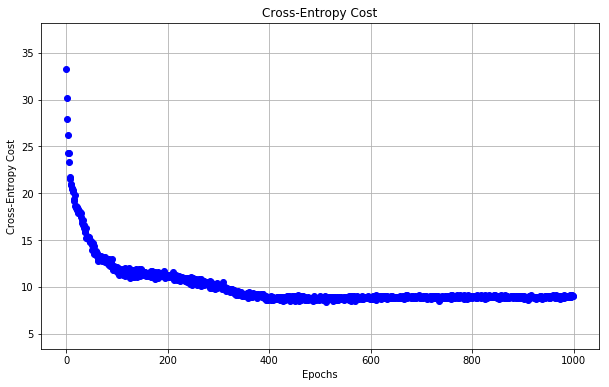

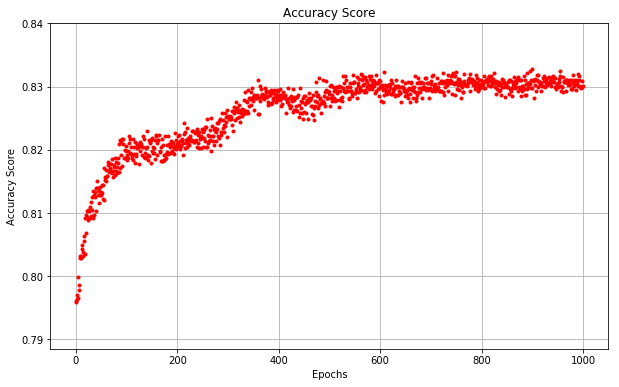

In [0]:
plotCost(nnModel.get_cost_histroy(), epoch )
plotAccuracy(nnModel.get_accuracy_histroy(), epoch )

In [0]:
y_pred = nnModel.predict(X_test)
y_pred = (y_pred >= 0.5)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1541   54]
 [ 260  145]]

Accuracy Score: 0.843

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1595
           1       0.73      0.36      0.48       405

    accuracy                           0.84      2000
   macro avg       0.79      0.66      0.69      2000
weighted avg       0.83      0.84      0.82      2000

